### Grokking example
We're just going to reproduce the experiments shown in the repo mentioned in "info.md"

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.chdir('/data/se24/geom_phase_transitions')
print(os.getcwd())

/data/se24/geom_phase_transitions


In [2]:
from training import ExperimentParams
experiment_name = "arithmetic_experiment3"

df_loss = pd.read_csv(f"./results/{experiment_name}/loss_data.csv")
params = pd.read_csv(f"./results/{experiment_name}/params.csv").to_dict(orient='list')
params = {k: v[0] for k, v in params.items()}  # Convert to a dictionary with single values
params = ExperimentParams(**params)

Text(0.5, 1.0, 'Train & test correct answer % for modular addition with p=53')

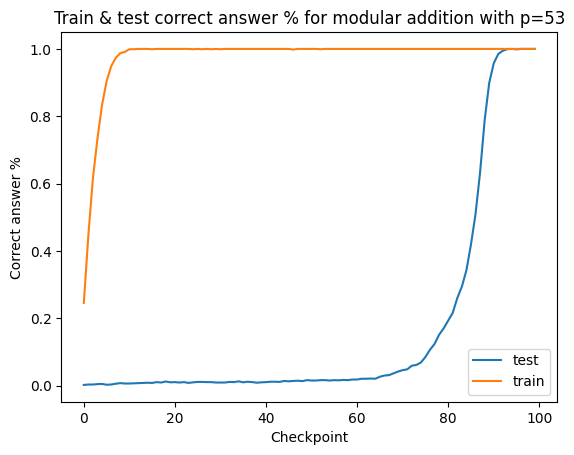

In [4]:
plt.plot(df_loss["val_acc"], label="test")
plt.plot(df_loss["train_acc"], label="train")
plt.legend()
plt.ylabel("Correct answer %")
plt.xlabel("Checkpoint")
plt.title(f"Train & test correct answer % for modular addition with p={params.p}")

Text(0.5, 1.0, 'Train & test loss for modular addition with p=53')

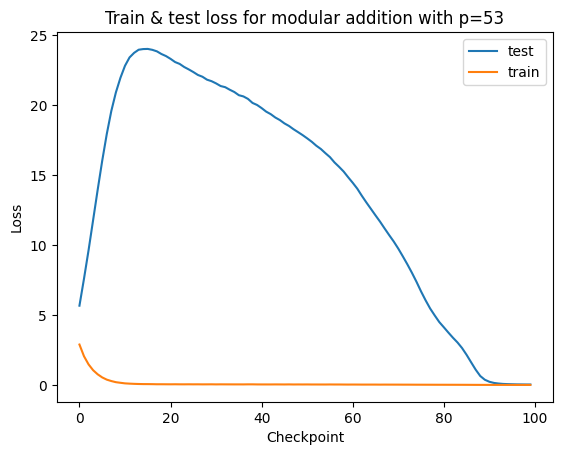

In [5]:
plt.plot(df_loss["val_loss"], label="test")
plt.plot(df_loss["train_loss"], label="train")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Checkpoint")
plt.title(f"Train & test loss for modular addition with p={params.p}")

### LLC Analysis
Hey there! Here comes the LLC stuff

In [6]:
from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce
import torch
from torch.utils.data import DataLoader
from arithmetic_models import MLP

train_data = torch.load(f"./results/{experiment_name}/datasets/train_data.pt")

In [8]:
lr = 3e-3
gamma = 5
nbeta = 2.0
num_draws = 500
num_chains = 2
llcs = []
n_checkpoints = params.n_save_model_checkpoints
check_points_every = params.epochs // params.print_times
model = MLP(params)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
model.eval()
for i in range(n_checkpoints):
    try:
        model.load_state_dict(torch.load(f"./results/{experiment_name}/checkpoints/model_{(i+1) * check_points_every}.pt"))
    except FileNotFoundError:
        continue
    llcs.append(estimate_learning_coeff_with_summary(
        model=model,
        loader=DataLoader(train_data, batch_size=params.batch_size, shuffle=True),
        evaluate=evaluate_ce,
        sampling_method=SGLD,
        optimizer_kwargs=dict(lr=0.003, nbeta=2.0, localization=5.0),
        num_chains=3,
        num_draws=500,
        device=DEVICE,
        online=False,
    )['llc/mean'])

df_loss = pd.read_csv(f"./results/{experiment_name}/loss_data.csv")
df_loss["llc"] = llcs
df_loss.to_csv(f"./results/{experiment_name}/loss_data.csv", index=False)


/home/se24/geom_phase_transitions/.venv/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/se24/geom_phase_transitions/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/se24/geom_phase_transitions/.venv/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/se24/geom_phase_transitions/.venv/lib/python3.10/site-pack

NameError: name 'df_loss' is not defined

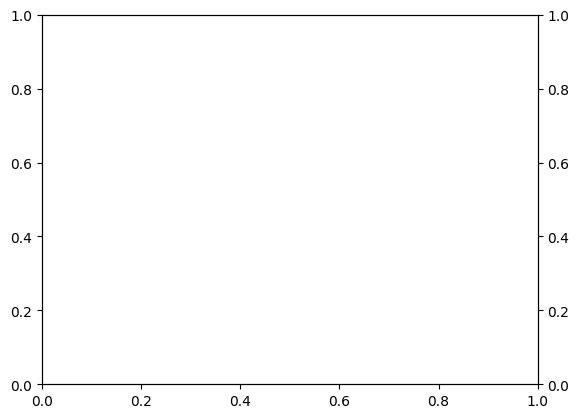

In [2]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_loss["llc"], color='tab:blue', label="LLC")
ax2.plot(df_loss["val_loss"], color='tab:orange', label="Test Loss")
ax2.plot(df_loss["train_loss"], color='tab:green', label="Train Loss")

ax1.set_ylabel("LLC")
ax2.set_ylabel("Losses")
ax1.set_xlabel("Checkpoint")

plt.title(f"LLC and Losses for modular addition with p={params.p}")
fig.legend()
plt.show()

### Studying the correlation between the curves


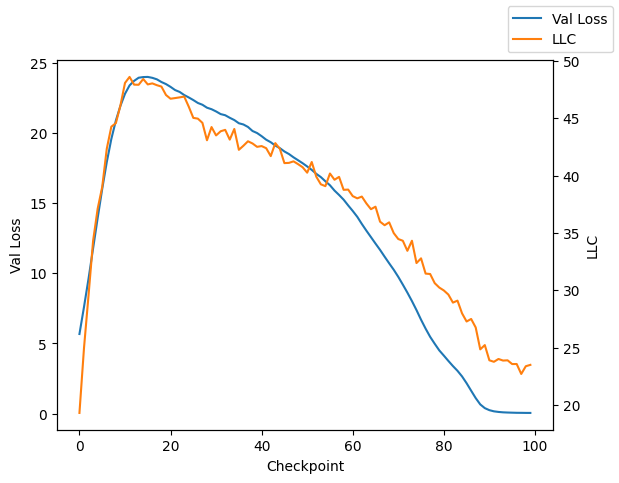

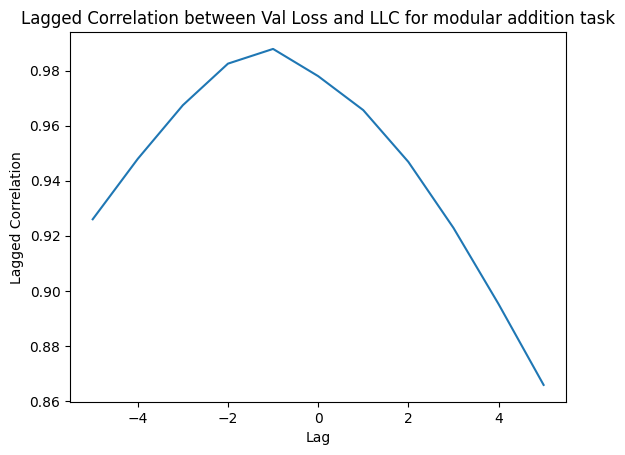

In [3]:
from utils.metrics import list_lagged_correlation
experiment_name = "arithmetic_experiment2"
results = pd.read_csv(f"./results/{experiment_name}/loss_data.csv")
val_loss = results["val_loss"].values
llc = results["llc"].values
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(val_loss, color='tab:blue', label="Val Loss")
ax2.plot(llc, color='tab:orange', label="LLC")
ax1.set_ylabel("Val Loss")
ax2.set_ylabel("LLC")
ax1.set_xlabel("Checkpoint")
fig.legend()
plt.show()

max_lag = 5
lagged_corr = list_lagged_correlation(llc, val_loss, max_lag=max_lag)
lags = range(-max_lag, max_lag + 1)
plt.plot(lags, lagged_corr)
plt.xlabel("Lag")
plt.ylabel("Lagged Correlation")
plt.title(f"Lagged Correlation between Val Loss and LLC for modular addition task")
plt.show()


We're looking at the correlation between x_t and y_{t+lag}. Here, the lagged correlation between x_t= llc_t and y_t = val_loss_t, reaches it's maximum at lag=-1. This seems to indicate that a change in the generalisation error comes slightly beefore a change in the llc? Check logic!